# Performing EDA on Intel Image Classification dataet link:https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [4]:
import os 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd


Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Number of images per class:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


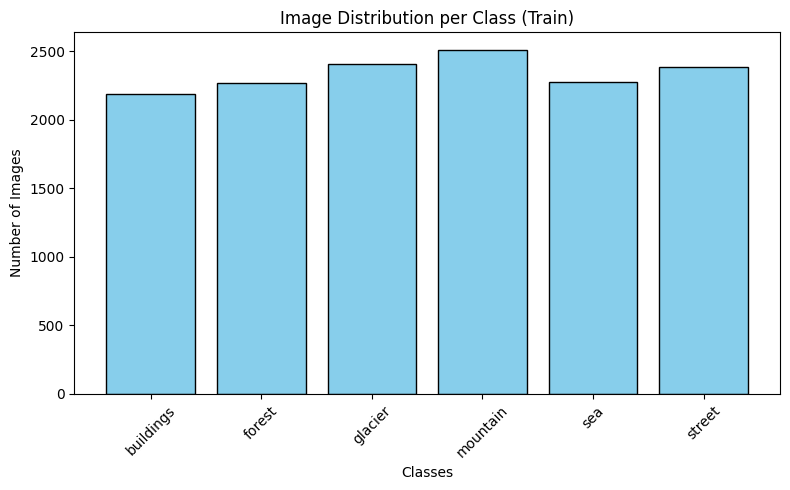


Checking image sizes and displaying sample images:
buildings sample image size: (150, 150)


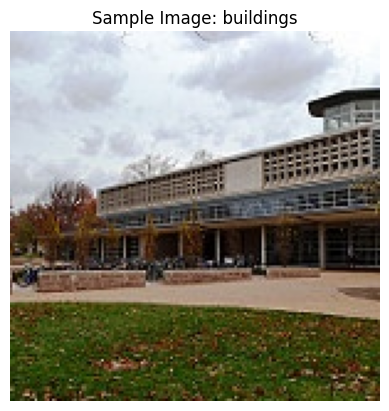

forest sample image size: (150, 150)


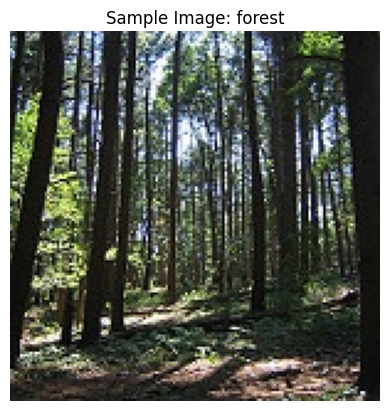

glacier sample image size: (150, 150)


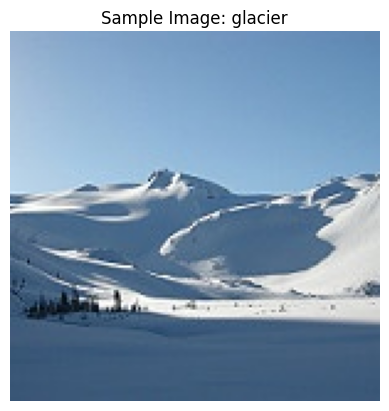

mountain sample image size: (150, 150)


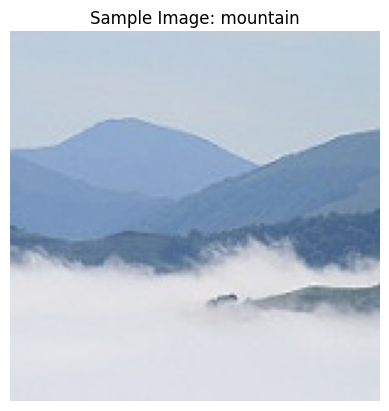

sea sample image size: (150, 150)


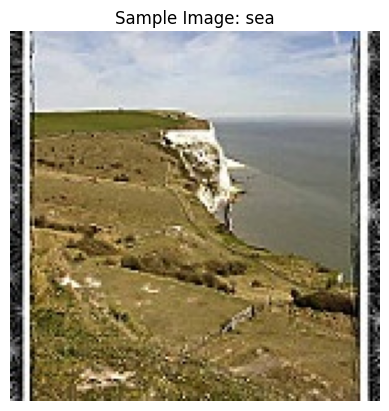

street sample image size: (150, 150)


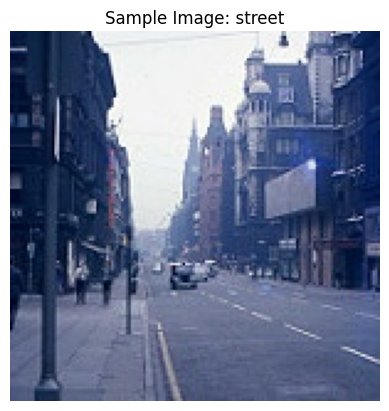

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the training directory path (adjust if needed)
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

# Get list of class directories (e.g., 'buildings', 'forest', etc.)
classes = sorted(os.listdir(train_dir))
print("Classes found:", classes)

# Initialize dictionary to count images per class
class_counts = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    # List only image files (you might add a filter for file extensions if needed)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    count = len(images)
    class_counts[class_name] = count

# Display counts per class
print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot a bar chart for image distribution across classes
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Image Distribution per Class (Train)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check image sizes and display one sample image from each class
print("\nChecking image sizes and displaying sample images:")
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if not image_files:
        continue
    sample_img_path = os.path.join(class_path, image_files[0])
    image = Image.open(sample_img_path)
    print(f"{class_name} sample image size: {image.size}")
    
    # Display sample image
    plt.figure()
    plt.imshow(image)
    plt.title(f"Sample Image: {class_name}")
    plt.axis('off')
    plt.show()



Average brightness per class:
buildings: 117.42
forest: 78.62
glacier: 136.66
mountain: 122.59
sea: 131.42
street: 107.39


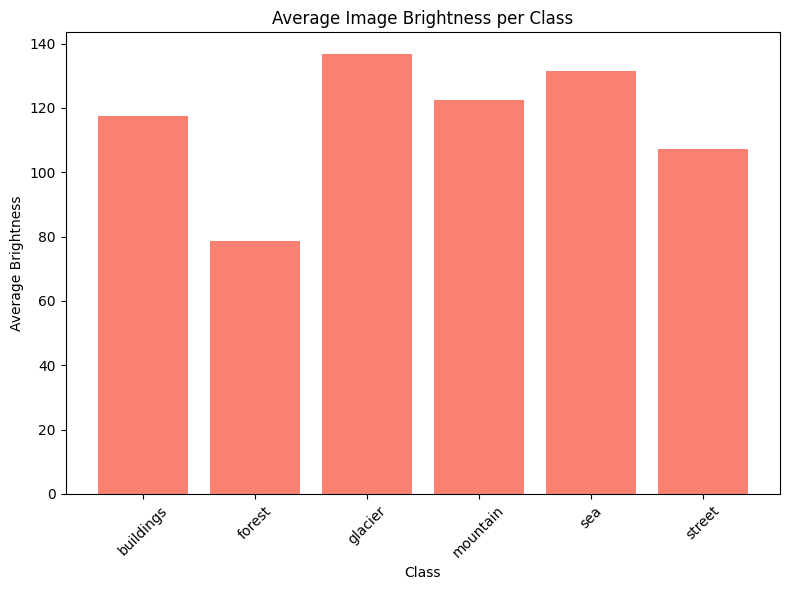

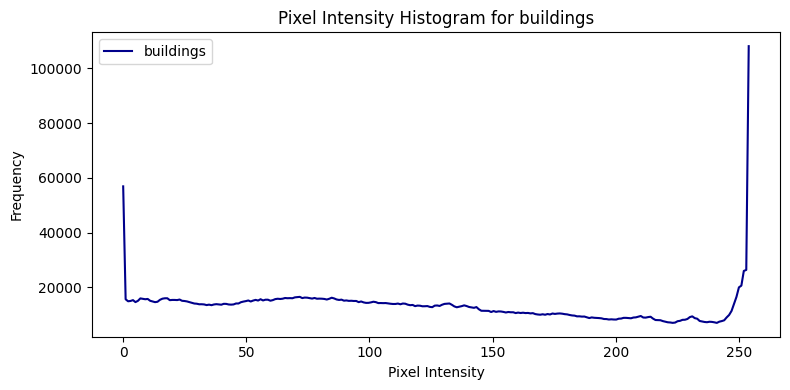

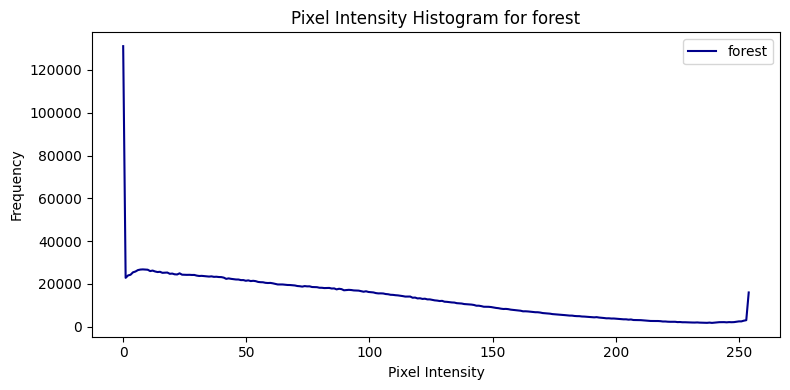

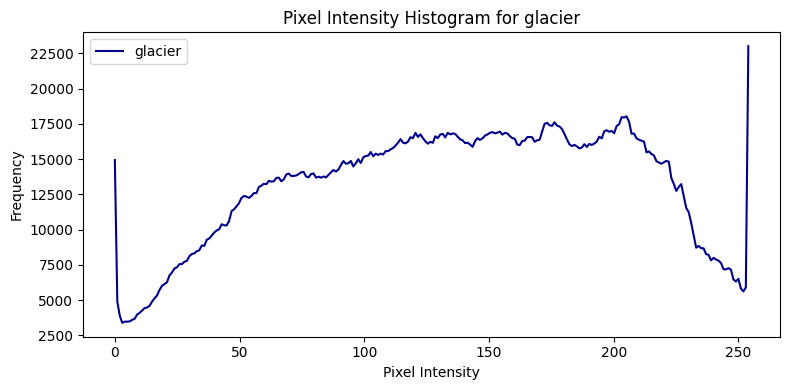

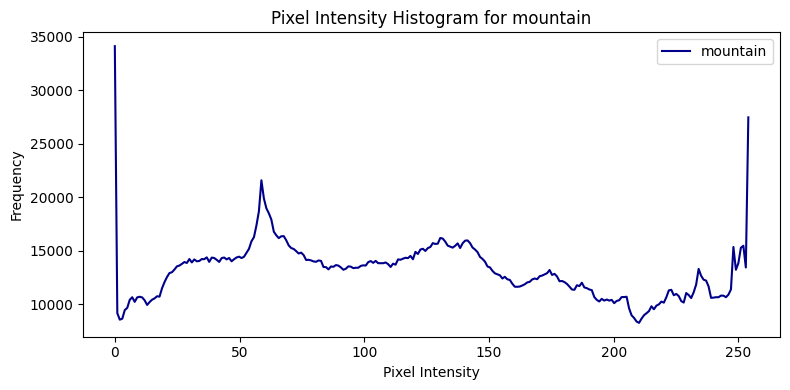

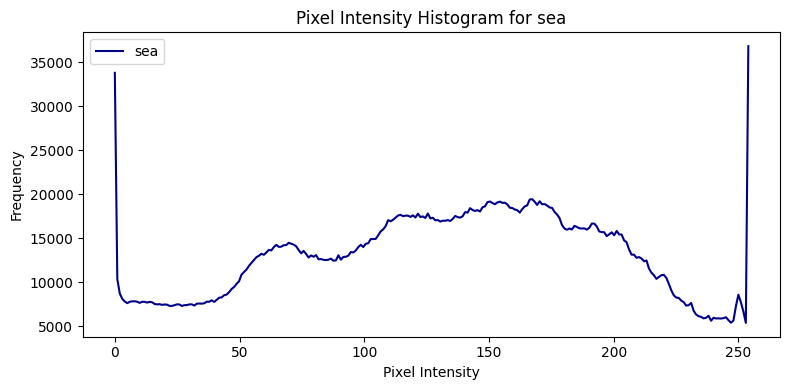

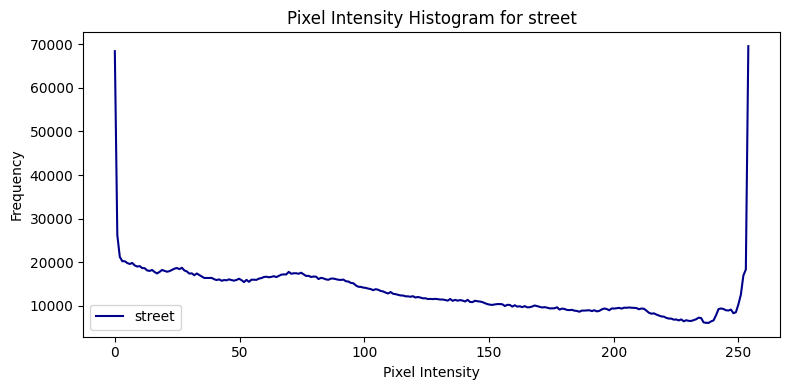

In [5]:

# 2. Extended Analysis: Brightness & Histograms
# We'll sample a fixed number of images per class to compute statistics
num_samples = 50
class_brightness = {}
class_pixel_histograms = {}

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    brightness_values = []
    all_pixels = []
    
    # Get a sample (if fewer images than sample count, take all)
    sample_files = image_files[:num_samples] if len(image_files) >= num_samples else image_files
    for file in sample_files:
        image_path = os.path.join(class_path, file)
        try:
            img = Image.open(image_path)
            # Ensure image is in RGB mode
            if img.mode != 'RGB':
                img = img.convert('RGB')
            # Convert to numpy array
            img_array = np.array(img)
            # Compute brightness as the average of all pixel values (across all channels)
            brightness = img_array.mean()
            brightness_values.append(brightness)
            all_pixels.extend(img_array.flatten())
        except Exception as e:
            print("Error processing image:", image_path, e)
    
    # Save average brightness for the class
    if brightness_values:
        class_brightness[class_name] = np.mean(brightness_values)
    else:
        class_brightness[class_name] = None
    
    # Compute histogram for pixel intensities (range 0 to 255)
    histogram, bin_edges = np.histogram(all_pixels, bins=256, range=(0, 255))
    class_pixel_histograms[class_name] = (histogram, bin_edges)

# Print and plot average brightness per class
print("\nAverage brightness per class:")
for class_name, brightness in class_brightness.items():
    print(f"{class_name}: {brightness:.2f}")

plt.figure(figsize=(8,6))
plt.bar(class_brightness.keys(), class_brightness.values(), color='salmon')
plt.xlabel("Class")
plt.ylabel("Average Brightness")
plt.title("Average Image Brightness per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot pixel intensity histograms for each class
for class_name, (histogram, bin_edges) in class_pixel_histograms.items():
    plt.figure(figsize=(8,4))
    plt.plot(bin_edges[:-1], histogram, label=f"{class_name}", color='darkblue')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title(f"Pixel Intensity Histogram for {class_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

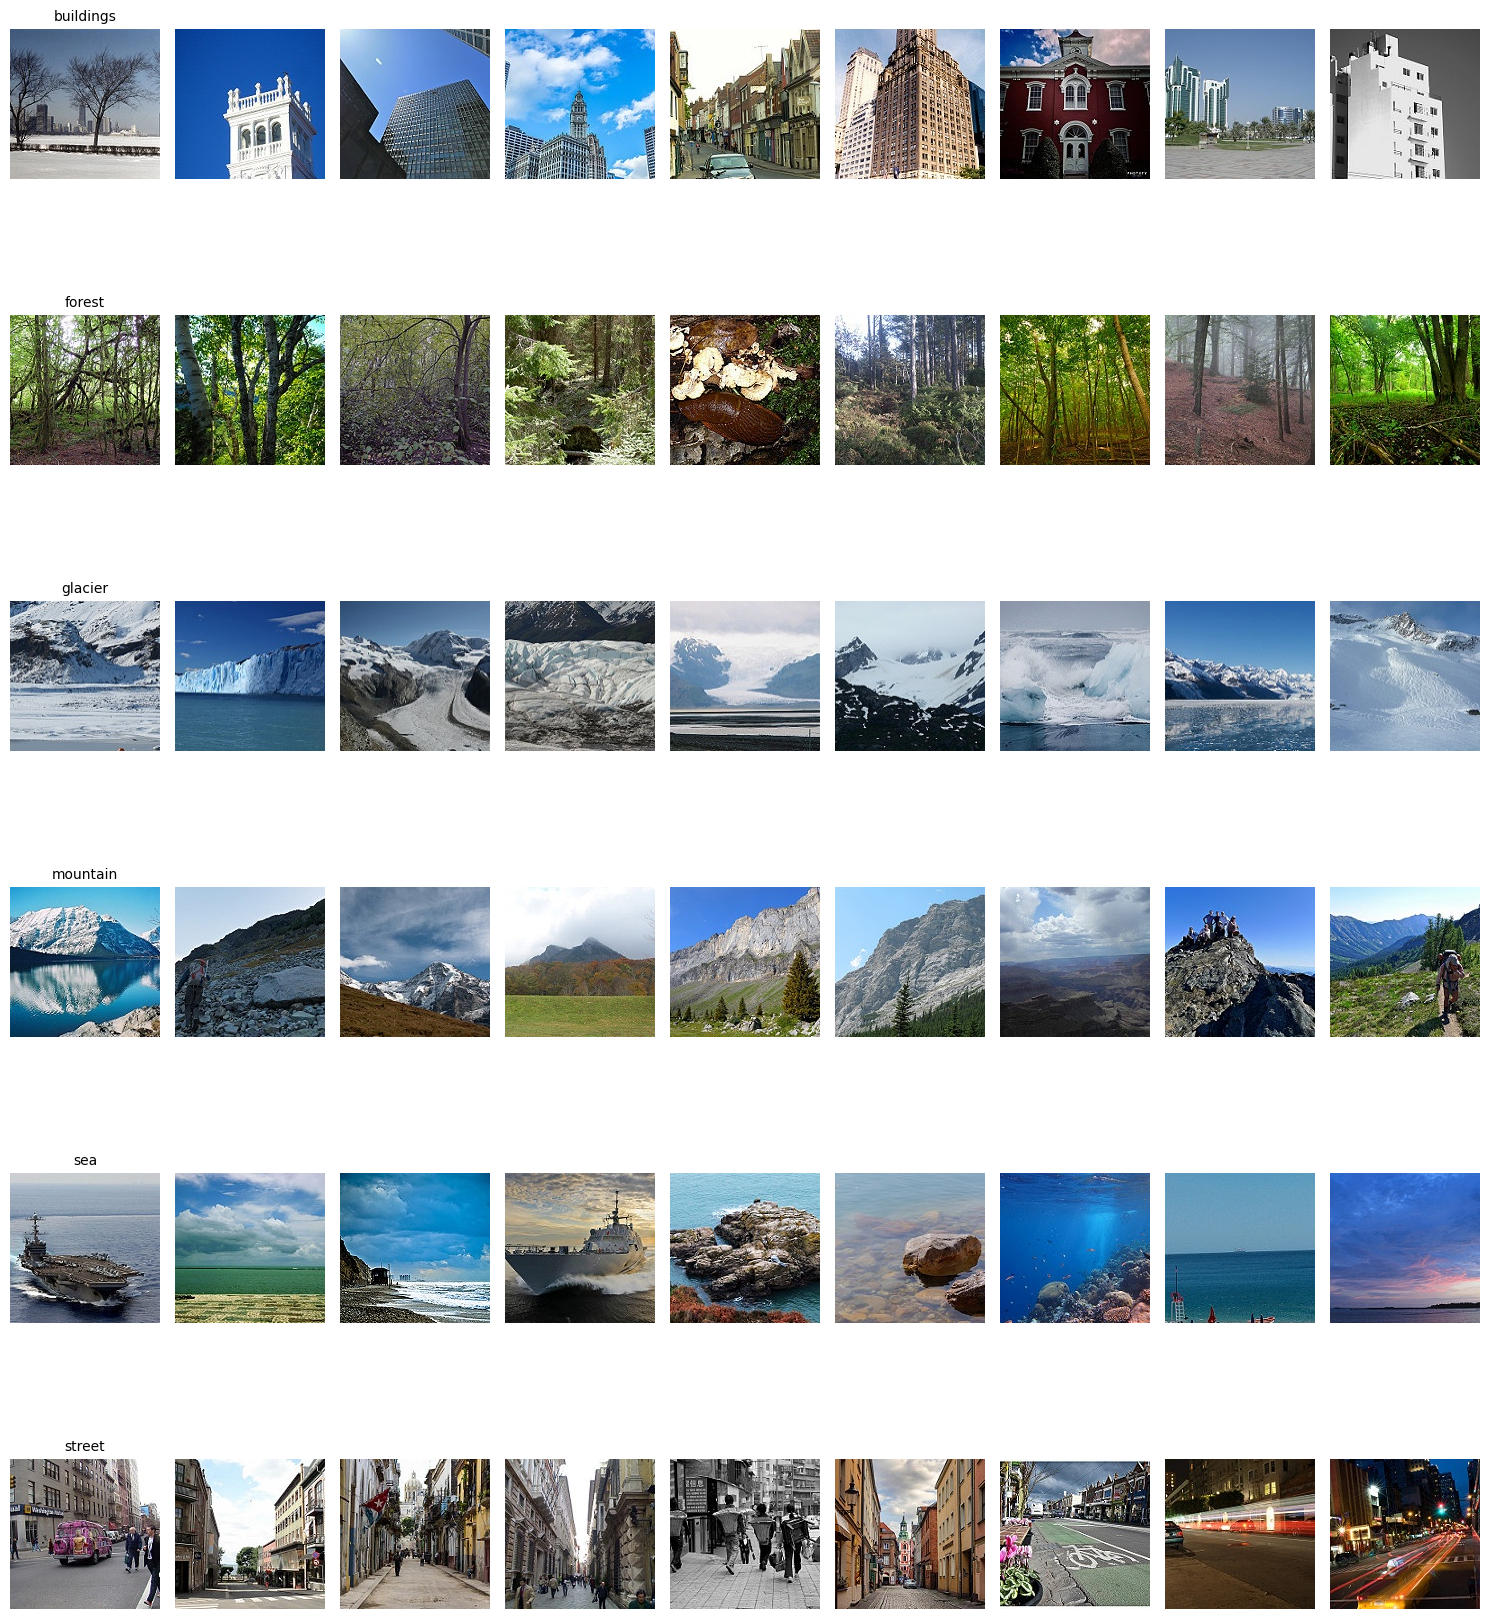

In [7]:
# 3. Visual Montage of Sample Images
import random
num_samples_per_class = 9  # Create a grid of 9 images per class
ncols = num_samples_per_class
nrows = len(classes)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))
for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    # Randomly sample images for montage (if available images are less, use all)
    sampled_files = random.sample(image_files, min(num_samples_per_class, len(image_files)))
    for j in range(num_samples_per_class):
        ax = axes[i, j] if nrows > 1 else axes[j]
        ax.axis('off')
        if j < len(sampled_files):
            img = Image.open(os.path.join(class_path, sampled_files[j]))
            ax.imshow(img)
            if j == 0:
                ax.set_title(class_name, fontsize=10)
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()

# ConvNext: A Contemporary Architecture for Convolutional Neural Networks for Image Classification(Best Model)

In [4]:

import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Preparation
# ----------------------------
# Define the paths to the nested training and testing directories
# Note: Adjust these paths if your structure is different.
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir  = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Data augmentation and normalization for training,
# and normalization for validation/testing.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Create datasets using ImageFolder (assumes images are organized by class)
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

# Create DataLoaders
batch_size = 32
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=2)
    for x in ['train', 'val']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print("Classes: ", class_names)
print("Train samples: ", dataset_sizes['train'])
print("Validation samples: ", dataset_sizes['val'])

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 2. Model Creation
# ----------------------------
# Use a pretrained ConvNeXt Tiny model.
model_convnext = models.convnext_tiny(pretrained=True)
# Modify the classifier head for our 6 classes
num_ftrs = model_convnext.classifier[2].in_features
model_convnext.classifier[2] = nn.Linear(num_ftrs, len(class_names))  # 6 classes in Intel dataset

# Wrap model for parallel processing if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training!")
    model_convnext = nn.DataParallel(model_convnext)

model_convnext = model_convnext.to(device)

# ----------------------------
# 3. Loss, Optimizer, and Learning Rate Scheduler
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer_convnext = optim.Adam(model_convnext.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_convnext, step_size=7, gamma=0.1)

# ----------------------------
# 4. Training and Validation Loop
# ----------------------------
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if validation accuracy improves.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights.
    model.load_state_dict(best_model_wts)
    return model

# Train the model (adjust num_epochs as needed)
num_epochs = 10
model_convnext = train_model(model_convnext, criterion, optimizer_convnext, exp_lr_scheduler, num_epochs=num_epochs)



Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train samples:  14034
Validation samples:  3000
Using device: cuda:0
Epoch 1/10
------------------------------
Train Loss: 0.2528 Acc: 0.9151
Val Loss: 0.1777 Acc: 0.9397

Epoch 2/10
------------------------------
Train Loss: 0.1369 Acc: 0.9535
Val Loss: 0.1652 Acc: 0.9393

Epoch 3/10
------------------------------
Train Loss: 0.1005 Acc: 0.9632
Val Loss: 0.1721 Acc: 0.9423

Epoch 4/10
------------------------------
Train Loss: 0.0726 Acc: 0.9731
Val Loss: 0.1712 Acc: 0.9423

Epoch 5/10
------------------------------
Train Loss: 0.0514 Acc: 0.9823
Val Loss: 0.1932 Acc: 0.9360

Epoch 6/10
------------------------------
Train Loss: 0.0447 Acc: 0.9848
Val Loss: 0.2180 Acc: 0.9443

Epoch 7/10
------------------------------
Train Loss: 0.0394 Acc: 0.9862
Val Loss: 0.2063 Acc: 0.9427

Epoch 8/10
------------------------------
Train Loss: 0.0144 Acc: 0.9957
Val Loss: 0.1851 Acc: 0.9497

Epoch 9/10
----------------------

In [5]:
# ----------------------------
# 5. Save the Trained Model
# ----------------------------
model_save_path = '/kaggle/working/convnext_intel.pth'
torch.save(model_convnext.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")


Best model saved to /kaggle/working/convnext_intel.pth


# Testing ConvNext Model

Test Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of Test Samples: 3000


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and set to evaluation mode.


<ipython-input-13-e7ec84f2b70e>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_convnext.load_state_dict(torch.load(model_save_path, map_location=device))


Accuracy: 0.9503
Macro Precision: 0.9512
Macro Recall: 0.9517
Macro F1 Score: 0.9513
Weighted Precision: 0.9503
Weighted Recall: 0.9503
Weighted F1 Score: 0.9502
Log Loss: 0.2054

Confusion Matrix:
 [[414   0   0   0   1  22]
 [  0 471   1   1   1   0]
 [  0   1 496  46  10   0]
 [  0   1  34 486   3   1]
 [  3   0   1   1 504   1]
 [ 20   0   0   0   1 480]]

Classification Report:
               precision    recall  f1-score   support

   buildings       0.95      0.95      0.95       437
      forest       1.00      0.99      0.99       474
     glacier       0.93      0.90      0.91       553
    mountain       0.91      0.93      0.92       525
         sea       0.97      0.99      0.98       510
      street       0.95      0.96      0.96       501

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Class 'buildings' AUC: 1.00
Class 'forest' AUC: 1.00
Class 'glacier' A

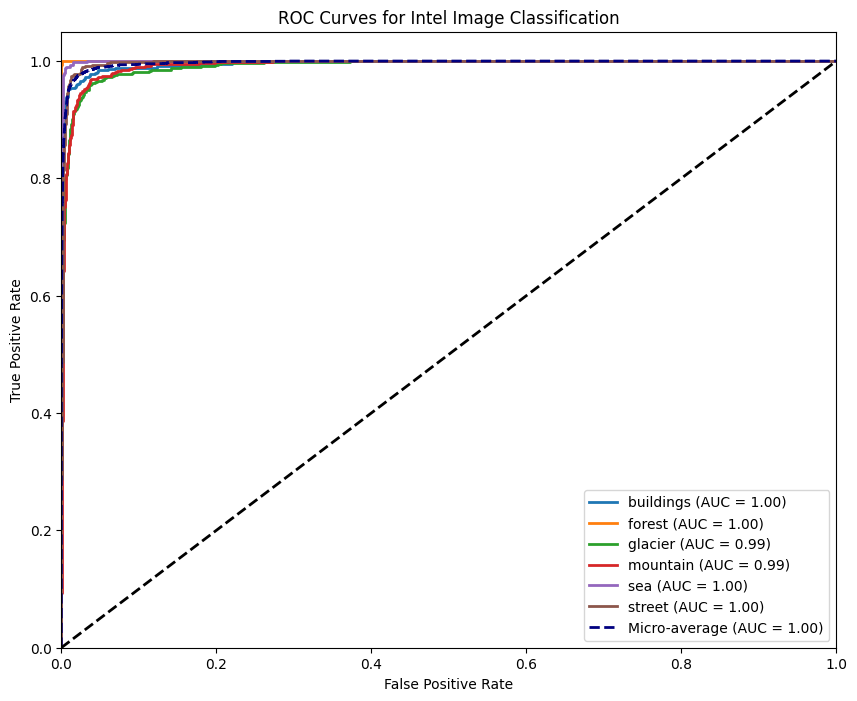

In [13]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, log_loss,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. Test Dataset Preparation
# ----------------------------
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the test dataset (labels are assigned based on folder names)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = test_dataset.classes
n_classes = len(class_names)
print("Test Classes:", class_names)
print("Number of Test Samples:", len(test_dataset))

# ----------------------------
# 2. Model Initialization & Loading Weights
# ----------------------------
# Reinitialize ConvNeXt Tiny and modify its classifier head.
model_convnext = models.convnext_tiny(pretrained=False)
num_ftrs = model_convnext.classifier[2].in_features
model_convnext.classifier[2] = nn.Linear(num_ftrs, n_classes)  # 6 classes

# If multiple GPUs are available, use DataParallel.
if torch.cuda.device_count() > 1:
    model_convnext = nn.DataParallel(model_convnext)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_convnext = model_convnext.to(device)

# Load the saved model weights.
model_save_path = '/kaggle/working/convnext_intel.pth'
model_convnext.load_state_dict(torch.load(model_save_path, map_location=device))
model_convnext.eval()
print("Model loaded and set to evaluation mode.")

# ----------------------------
# 3. Model Inference on Test Dataset
# ----------------------------
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_convnext(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.concatenate(all_probs, axis=0)

# ----------------------------
# 4. Compute Evaluation Metrics
# ----------------------------
# Overall Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Precision, Recall, F1 Scores (Macro and Weighted)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro    = recall_score(all_labels, all_preds, average='macro')
f1_macro        = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted    = recall_score(all_labels, all_preds, average='weighted')
f1_weighted        = f1_score(all_labels, all_preds, average='weighted')

# Log Loss
loss = log_loss(all_labels, all_probs)

# Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_names)

print("Accuracy: {:.4f}".format(accuracy))
print("Macro Precision: {:.4f}".format(precision_macro))
print("Macro Recall: {:.4f}".format(recall_macro))
print("Macro F1 Score: {:.4f}".format(f1_macro))
print("Weighted Precision: {:.4f}".format(precision_weighted))
print("Weighted Recall: {:.4f}".format(recall_weighted))
print("Weighted F1 Score: {:.4f}".format(f1_weighted))
print("Log Loss: {:.4f}".format(loss))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# ----------------------------
# 5. ROC Curves and AUC Calculation
# ----------------------------
# Binarize the true labels for multi-class ROC computation.
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    print(f"Class '{class_names[i]}' AUC: {roc_auc[i]:.2f}")

# Compute micro-average ROC curve and AUC.
fpr_micro, tpr_micro, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='navy', lw=2, linestyle='--',
         label=f"Micro-average (AUC = {roc_auc_micro:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Intel Image Classification")
plt.legend(loc="lower right")
plt.show()


# Trying variations of Transformers

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train samples: 14034
Val samples: 3000
Test samples: 3000
Using device: cuda:0
Training and Evaluating Model: mobilevit
[mobilevit] Detected feature dimension: 15680
Epoch 1/10
----------------------------------------
Train Loss: 0.3586 Acc: 0.8797
Val Loss: 0.2164 Acc: 0.9233

Epoch 2/10
----------------------------------------
Train Loss: 0.1995 Acc: 0.9285
Val Loss: 0.1974 Acc: 0.9277

Epoch 3/10
----------------------------------------
Train Loss: 0.1655 Acc: 0.9413
Val Loss: 0.1858 Acc: 0.9337

Epoch 4/10
----------------------------------------
Train Loss: 0.1386 Acc: 0.9507
Val Loss: 0.2002 Acc: 0.9287

Epoch 5/10
----------------------------------------
Train Loss: 0.1147 Acc: 0.9586
Val Loss: 0.1957 Acc: 0.9367

Epoch 6/10
----------------------------------------
Train Loss: 0.1004 Acc: 0.9641
Val Loss: 0.1996 Acc: 0.9293

Epoch 7/10
----------------------------------------
Train Loss: 0.0853 Acc: 0.9701


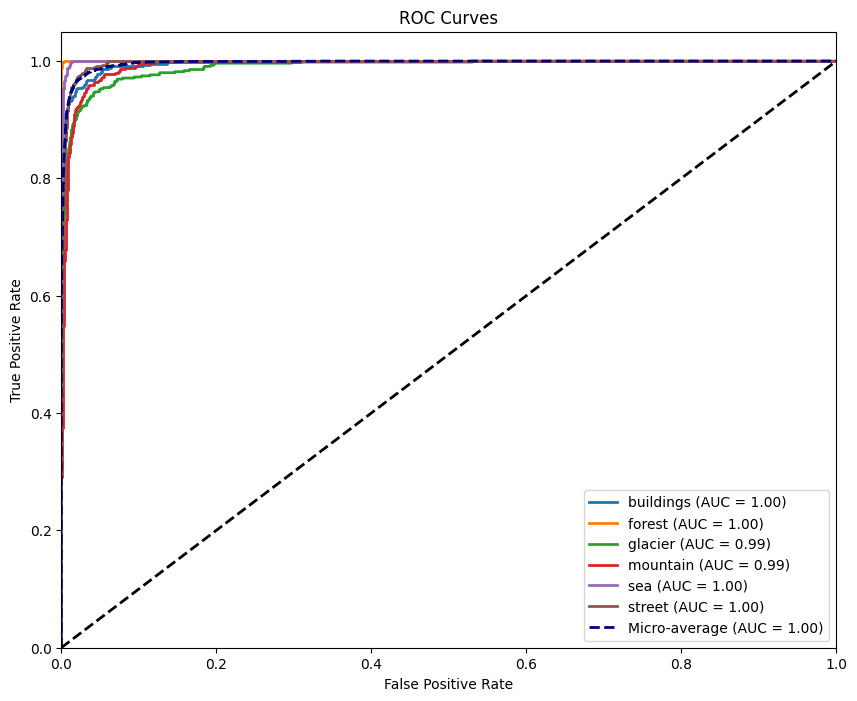

Model weights saved as mobilevit_intel.pth

Training and Evaluating Model: swin
[swin] Detected feature dimension: 37632
Epoch 1/10
----------------------------------------
Train Loss: 0.2629 Acc: 0.9052
Val Loss: 0.1908 Acc: 0.9293

Epoch 2/10
----------------------------------------
Train Loss: 0.1772 Acc: 0.9394
Val Loss: 0.2934 Acc: 0.9043

Epoch 3/10
----------------------------------------
Train Loss: 0.1455 Acc: 0.9475
Val Loss: 0.2096 Acc: 0.9257

Epoch 4/10
----------------------------------------
Train Loss: 0.1113 Acc: 0.9601
Val Loss: 0.1764 Acc: 0.9413

Epoch 5/10
----------------------------------------
Train Loss: 0.1172 Acc: 0.9585
Val Loss: 0.1959 Acc: 0.9333

Epoch 6/10
----------------------------------------
Train Loss: 0.0988 Acc: 0.9642
Val Loss: 0.1995 Acc: 0.9330

Epoch 7/10
----------------------------------------
Train Loss: 0.0821 Acc: 0.9701
Val Loss: 0.2316 Acc: 0.9340

Epoch 8/10
----------------------------------------
Train Loss: 0.0340 Acc: 0.9890
Val L

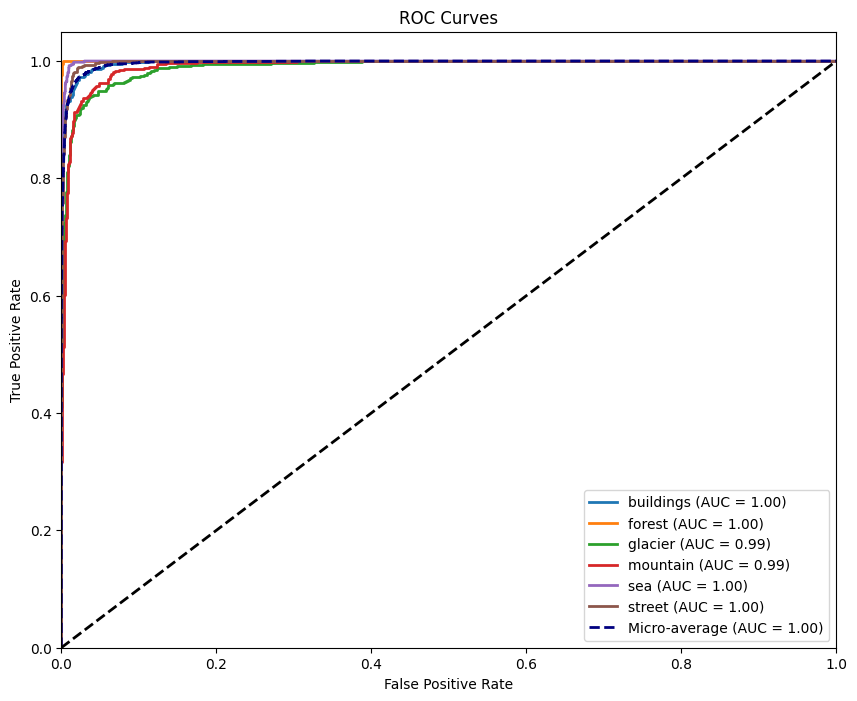

Model weights saved as swin_intel.pth

Training and Evaluating Model: vit
[vit] Detected feature dimension: 151296
Epoch 1/10
----------------------------------------
Train Loss: 0.4520 Acc: 0.8710
Val Loss: 0.2947 Acc: 0.8900

Epoch 2/10
----------------------------------------
Train Loss: 0.2167 Acc: 0.9256
Val Loss: 0.2586 Acc: 0.9193

Epoch 3/10
----------------------------------------
Train Loss: 0.2049 Acc: 0.9326
Val Loss: 0.2446 Acc: 0.9200

Epoch 4/10
----------------------------------------
Train Loss: 0.1737 Acc: 0.9387
Val Loss: 0.3116 Acc: 0.9087

Epoch 5/10
----------------------------------------
Train Loss: 0.1605 Acc: 0.9460
Val Loss: 0.3212 Acc: 0.9003

Epoch 6/10
----------------------------------------
Train Loss: 0.1637 Acc: 0.9461
Val Loss: 0.2609 Acc: 0.9197

Epoch 7/10
----------------------------------------
Train Loss: 0.1152 Acc: 0.9607
Val Loss: 0.3050 Acc: 0.9160

Epoch 8/10
----------------------------------------
Train Loss: 0.0336 Acc: 0.9878
Val Loss: 0

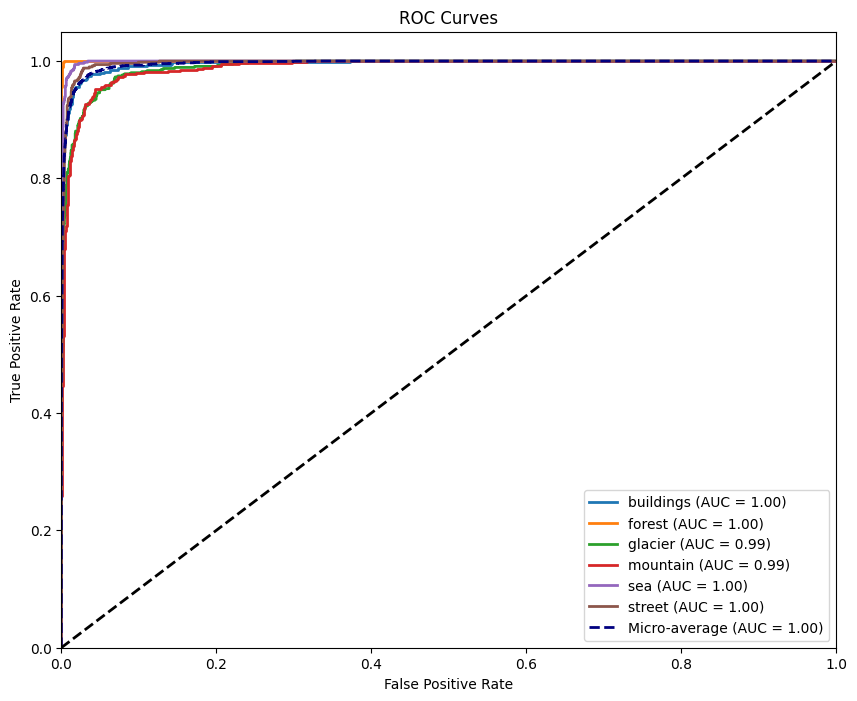

Model weights saved as vit_intel.pth



In [2]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm  # pip install timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, log_loss,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize

#########################################
# 1. Data Preparation
#########################################
# Define paths (adjust these paths if needed)
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
val_dir   = '/kaggle/input/intel-image-classification/seg_test/seg_test'
test_dir  = val_dir  # For this example, we use the validation set as test set

# Define transforms for training, validation, and testing.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# Create datasets using ImageFolder (labels assigned automatically)
datasets_dict = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])
}

# Create DataLoaders (set num_workers=0 on Kaggle for stability)
batch_size = 32
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=0)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'val', 'test']}
class_names = datasets_dict['train'].classes
n_classes = len(class_names)

print("Classes:", class_names, flush=True)
print("Train samples:", dataset_sizes['train'], flush=True)
print("Val samples:", dataset_sizes['val'], flush=True)
print("Test samples:", dataset_sizes['test'], flush=True)

#########################################
# Global Device Setup
#########################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, flush=True)

#########################################
# 2. Model Factory Function with Forward Override
#########################################
def fix_model_classifier(model, model_name, num_classes, device):
    """
    Moves the model to device, runs a dummy input through forward_features to detect 
    the feature dimension, replaces the classifier head, and overrides the forward
    method to ensure consistency.
    """
    model = model.to(device)
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        if hasattr(model, "forward_features"):
            features = model.forward_features(dummy_input)
        else:
            features = model(dummy_input)
    features = features.view(features.size(0), -1)
    in_features = features.size(1)
    print(f"[{model_name}] Detected feature dimension: {in_features}", flush=True)
    
    if hasattr(model, 'head'):
        model.head = nn.Linear(in_features, num_classes).to(device)
    elif hasattr(model, 'classifier'):
        model.classifier = nn.Linear(in_features, num_classes).to(device)
    else:
        raise ValueError("Model does not have 'head' or 'classifier' attribute.")
    
    # Override forward to use forward_features (if available).
    if hasattr(model, "forward_features"):
        model.forward = lambda x: model.head(model.forward_features(x).view(x.size(0), -1))
    return model

def get_model(model_name, num_classes, device):
    """
    Returns a model with a modified classification head for the given model_name.
    Supported names: 'mobilevit', 'swin', 'vit'
    Note: 'swin' is used here as a substitute for maxvit.
    """
    if model_name == 'mobilevit':
        model = timm.create_model('mobilevit_xxs', pretrained=True)
    elif model_name == 'swin':
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
    elif model_name == 'vit':
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
    else:
        raise ValueError("Model name not recognized. Choose from 'mobilevit', 'swin', 'vit'.")
    
    model = fix_model_classifier(model, model_name, num_classes, device)
    return model

#########################################
# 3. Training Function
#########################################
def train_model_fn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}", flush=True)
        print("-" * 40, flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}", flush=True)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print("", flush=True)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s", flush=True)
    print(f"Best Val Acc: {best_acc:.4f}", flush=True)
    model.load_state_dict(best_model_wts)
    return model

#########################################
# 4. Evaluation Functions
#########################################
def evaluate_model_fn(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.concatenate(all_probs, axis=0)
    return all_labels, all_preds, all_probs

def compute_and_print_metrics(all_labels, all_preds, all_probs, class_names):
    n_classes = len(class_names)
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    recall_weighted = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    logloss = log_loss(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    print("----- Evaluation Metrics -----", flush=True)
    print("Accuracy: {:.4f}".format(accuracy), flush=True)
    print("Macro Precision: {:.4f}".format(precision_macro), flush=True)
    print("Macro Recall: {:.4f}".format(recall_macro), flush=True)
    print("Macro F1 Score: {:.4f}".format(f1_macro), flush=True)
    print("Weighted Precision: {:.4f}".format(precision_weighted), flush=True)
    print("Weighted Recall: {:.4f}".format(recall_weighted), flush=True)
    print("Weighted F1 Score: {:.4f}".format(f1_weighted), flush=True)
    print("Log Loss: {:.4f}".format(logloss), flush=True)
    print("\nConfusion Matrix:\n", cm, flush=True)
    print("\nClassification Report:\n", report, flush=True)
    
    all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
        print(f"Class '{class_names[i]}' AUC: {roc_auc[i]:.2f}", flush=True)
    
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color='navy', lw=2, linestyle='--',
             label=f"Micro-average (AUC = {roc_auc_micro:.2f})")
    
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

#########################################
# 5. Main Experiment Loop for Selected Models
#########################################
# We will experiment with three models: MobileViT, Swin-Tiny (as a proxy for MaxViT), and ViT.
model_names = ['mobilevit', 'swin', 'vit']
num_epochs = 10  # Reduced for debugging; increase as needed.
results = {}

for m_name in model_names:
    print("=" * 60, flush=True)
    print(f"Training and Evaluating Model: {m_name}", flush=True)
    
    # Get model with corrected classifier head.
    model = get_model(m_name, n_classes, device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_model = train_model_fn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    test_labels, test_preds, test_probs = evaluate_model_fn(best_model, dataloaders['test'])
    print(f"Results for Model: {m_name}", flush=True)
    compute_and_print_metrics(test_labels, test_preds, test_probs, class_names)
    
    results[m_name] = {
        "accuracy": accuracy_score(test_labels, test_preds),
        "precision_macro": precision_score(test_labels, test_preds, average='macro'),
        "recall_macro": recall_score(test_labels, test_preds, average='macro'),
        "f1_macro": f1_score(test_labels, test_preds, average='macro')
    }
    
    torch.save(best_model.state_dict(), f"{m_name}_intel.pth")
    print(f"Model weights saved as {m_name}_intel.pth\n", flush=True)


# Trying out CNN models (ResNet18, mobilenet_v2, efficientnet_b0)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train samples: 14034
Val samples: 3000
Test samples: 3000
Using device: cuda:0
Training and Evaluating Model: resnet18


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.0MB/s]


Epoch 1/10
----------------------------------------
Train Loss: 0.3056 Acc: 0.8947
Val Loss: 0.2194 Acc: 0.9267

Epoch 2/10
----------------------------------------
Train Loss: 0.1880 Acc: 0.9318
Val Loss: 0.1909 Acc: 0.9350

Epoch 3/10
----------------------------------------
Train Loss: 0.1469 Acc: 0.9478
Val Loss: 0.1957 Acc: 0.9273

Epoch 4/10
----------------------------------------
Train Loss: 0.1200 Acc: 0.9575
Val Loss: 0.2047 Acc: 0.9277

Epoch 5/10
----------------------------------------
Train Loss: 0.0978 Acc: 0.9659
Val Loss: 0.2048 Acc: 0.9333

Epoch 6/10
----------------------------------------
Train Loss: 0.0784 Acc: 0.9738
Val Loss: 0.2646 Acc: 0.9170

Epoch 7/10
----------------------------------------
Train Loss: 0.0739 Acc: 0.9742
Val Loss: 0.2052 Acc: 0.9363

Epoch 8/10
----------------------------------------
Train Loss: 0.0406 Acc: 0.9866
Val Loss: 0.1927 Acc: 0.9407

Epoch 9/10
----------------------------------------
Train Loss: 0.0280 Acc: 0.9912
Val Loss: 0.1

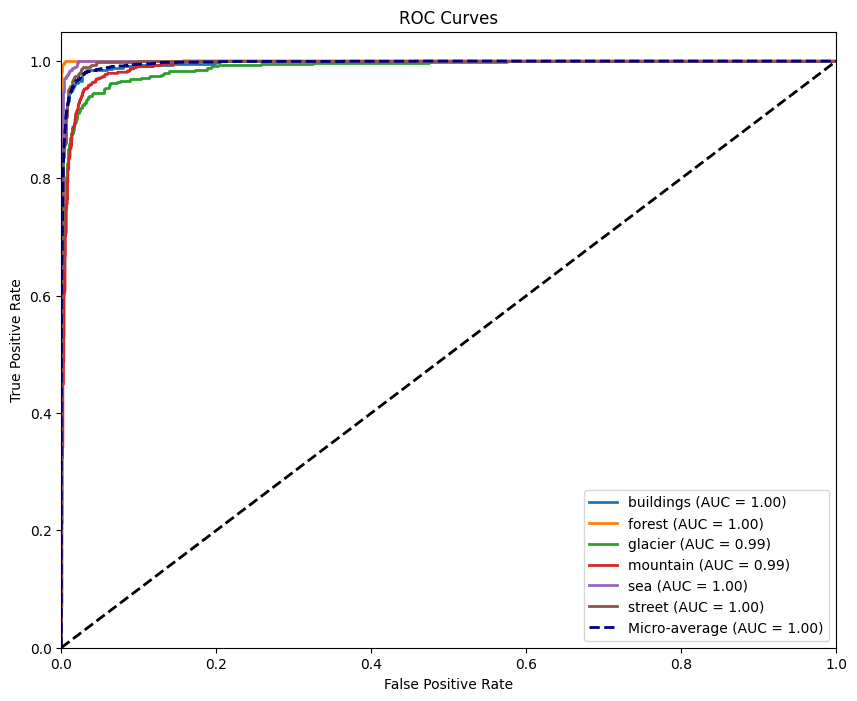

Model weights saved as resnet18_intel.pth

Training and Evaluating Model: mobilenet


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.1MB/s]

Epoch 1/10
----------------------------------------


Train Loss: 0.3177 Acc: 0.8901
Val Loss: 0.1885 Acc: 0.9323

Epoch 2/10
----------------------------------------
Train Loss: 0.2026 Acc: 0.9293
Val Loss: 0.1947 Acc: 0.9300

Epoch 3/10
----------------------------------------
Train Loss: 0.1607 Acc: 0.9438
Val Loss: 0.1909 Acc: 0.9340

Epoch 4/10
----------------------------------------
Train Loss: 0.1453 Acc: 0.9462
Val Loss: 0.1852 Acc: 0.9350

Epoch 5/10
----------------------------------------
Train Loss: 0.1192 Acc: 0.9573
Val Loss: 0.2139 Acc: 0.9247

Epoch 6/10
----------------------------------------
Train Loss: 0.1040 Acc: 0.9637
Val Loss: 0.2133 Acc: 0.9307

Epoch 7/10
----------------------------------------
Train Loss: 0.0856 Acc: 0.9687
Val Loss: 0.2333 Acc: 0.9290

Epoch 8/10
----------------------------------------
Train Loss: 0.0519 Acc: 0.9837
Val Loss: 0.1846 Acc: 0.9403

Epoch 9/10
----------------------------------------
Train Loss: 0.0403 Acc: 0.9879
Val Loss: 0.1877 Acc: 0.9410

Epoch 10/10
-----------------------

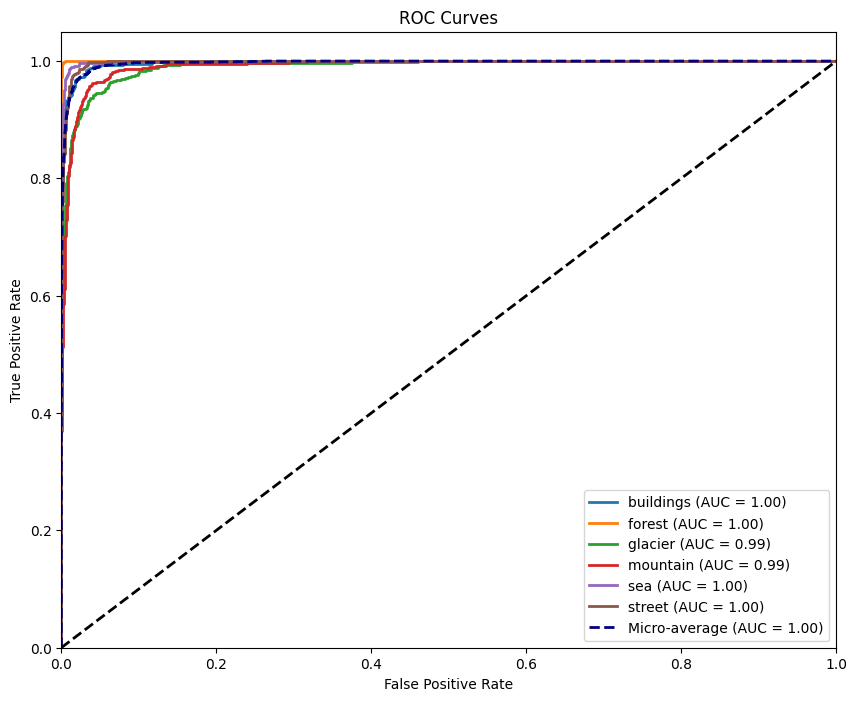

Model weights saved as mobilenet_intel.pth

Training and Evaluating Model: efficientnet


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 128MB/s]


Epoch 1/10
----------------------------------------
Train Loss: 0.4288 Acc: 0.8713
Val Loss: 0.1912 Acc: 0.9303

Epoch 2/10
----------------------------------------
Train Loss: 0.2017 Acc: 0.9291
Val Loss: 0.1799 Acc: 0.9377

Epoch 3/10
----------------------------------------
Train Loss: 0.1540 Acc: 0.9463
Val Loss: 0.1694 Acc: 0.9387

Epoch 4/10
----------------------------------------
Train Loss: 0.1193 Acc: 0.9575
Val Loss: 0.1635 Acc: 0.9387

Epoch 5/10
----------------------------------------
Train Loss: 0.1004 Acc: 0.9644
Val Loss: 0.1775 Acc: 0.9380

Epoch 6/10
----------------------------------------
Train Loss: 0.0771 Acc: 0.9719
Val Loss: 0.1735 Acc: 0.9397

Epoch 7/10
Train Loss: 0.0446 Acc: 0.9852
Val Loss: 0.1788 Acc: 0.9450

Epoch 9/10
----------------------------------------
Train Loss: 0.0390 Acc: 0.9872
Val Loss: 0.1875 Acc: 0.9410

Epoch 10/10
----------------------------------------
Train Loss: 0.0323 Acc: 0.9908
Val Loss: 0.1912 Acc: 0.9447

Training complete in 16

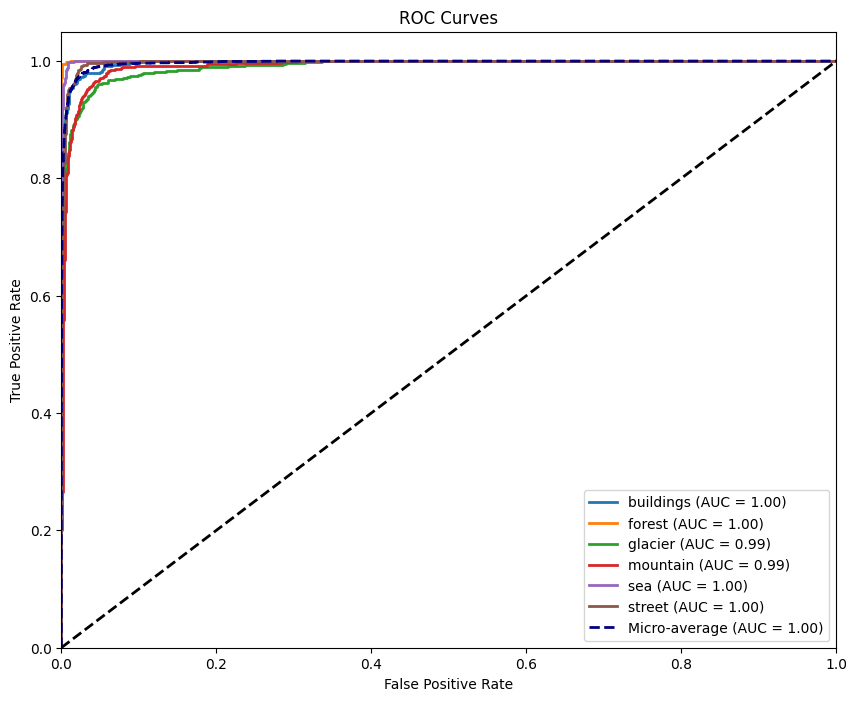

Model weights saved as efficientnet_intel.pth



In [2]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, log_loss,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize

#########################################
# 1. Data Preparation
#########################################
# Define paths (adjust these paths if needed)
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
val_dir   = '/kaggle/input/intel-image-classification/seg_test/seg_test'
test_dir  = val_dir  # Here, we use the validation set as the test set

# Define transforms for training, validation, and testing.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# Create datasets using ImageFolder (labels are automatically assigned)
datasets_dict = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])
}

# Create DataLoaders (set num_workers=0 for stability on Kaggle)
batch_size = 32
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=0)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'val', 'test']}
class_names = datasets_dict['train'].classes
n_classes = len(class_names)

print("Classes:", class_names, flush=True)
print("Train samples:", dataset_sizes['train'], flush=True)
print("Val samples:", dataset_sizes['val'], flush=True)
print("Test samples:", dataset_sizes['test'], flush=True)

#########################################
# Global Device Setup
#########################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, flush=True)

#########################################
# 2. Model Factory Function
#########################################
def get_model(model_name, num_classes, device):
    """
    Returns a model with a modified classifier head for the given model_name.
    Supported names: 'resnet18', 'mobilenet', 'efficientnet'
    """
    if model_name == 'resnet18':
        from torchvision.models import resnet18
        model = resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == 'mobilenet':
        from torchvision.models import mobilenet_v2
        model = mobilenet_v2(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == 'efficientnet':
        from torchvision.models import efficientnet_b0
        model = efficientnet_b0(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Model name not recognized. Choose from 'resnet18', 'mobilenet', 'efficientnet'.")
    
    model = model.to(device)
    return model

#########################################
# 3. Training Function
#########################################
def train_model_fn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}", flush=True)
        print("-" * 40, flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}", flush=True)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print("", flush=True)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s", flush=True)
    print(f"Best Val Acc: {best_acc:.4f}", flush=True)
    model.load_state_dict(best_model_wts)
    return model

#########################################
# 4. Evaluation Functions
#########################################
def evaluate_model_fn(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.concatenate(all_probs, axis=0)
    return all_labels, all_preds, all_probs

def compute_and_print_metrics(all_labels, all_preds, all_probs, class_names):
    n_classes = len(class_names)
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    recall_weighted = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    logloss = log_loss(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    print("----- Evaluation Metrics -----", flush=True)
    print("Accuracy: {:.4f}".format(accuracy), flush=True)
    print("Macro Precision: {:.4f}".format(precision_macro), flush=True)
    print("Macro Recall: {:.4f}".format(recall_macro), flush=True)
    print("Macro F1 Score: {:.4f}".format(f1_macro), flush=True)
    print("Weighted Precision: {:.4f}".format(precision_weighted), flush=True)
    print("Weighted Recall: {:.4f}".format(recall_weighted), flush=True)
    print("Weighted F1 Score: {:.4f}".format(f1_weighted), flush=True)
    print("Log Loss: {:.4f}".format(logloss), flush=True)
    print("\nConfusion Matrix:\n", cm, flush=True)
    print("\nClassification Report:\n", report, flush=True)
    
    all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10,8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
        print(f"Class '{class_names[i]}' AUC: {roc_auc[i]:.2f}", flush=True)
    
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color='navy', lw=2, linestyle='--',
             label=f"Micro-average (AUC = {roc_auc_micro:.2f})")
    
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()

#########################################
# 5. Main Experiment Loop for Selected Models
#########################################
# We will experiment with three models: ResNet-18, MobileNet-V2, and EfficientNet-B0.
model_names = ['resnet18', 'mobilenet', 'efficientnet']
num_epochs = 10  # Adjust as needed.
results = {}

for m_name in model_names:
    print("=" * 60, flush=True)
    print(f"Training and Evaluating Model: {m_name}", flush=True)
    
    # Get model with modified classifier head.
    model = get_model(m_name, n_classes, device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    best_model = train_model_fn(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    test_labels, test_preds, test_probs = evaluate_model_fn(best_model, dataloaders['test'])
    print(f"Results for Model: {m_name}", flush=True)
    compute_and_print_metrics(test_labels, test_preds, test_probs, class_names)
    
    results[m_name] = {
        "accuracy": accuracy_score(test_labels, test_preds),
        "precision_macro": precision_score(test_labels, test_preds, average='macro'),
        "recall_macro": recall_score(test_labels, test_preds, average='macro'),
        "f1_macro": f1_score(test_labels, test_preds, average='macro')
    }
    
    torch.save(best_model.state_dict(), f"/kaggle/working/{m_name}_intel.pth")
    print(f"Model weights saved as {m_name}_intel.pth\n", flush=True)
